In [9]:
import hdbscan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from graphviz import Digraph
from sklearn.metrics.pairwise import pairwise_distances
import scipy.spatial.distance
from sklearn.cluster import AgglomerativeClustering,FeatureAgglomeration,Birch
from scipy.cluster.hierarchy import dendrogram
import ete3
import time
from freediscovery.cluster import birch_hierarchy_wrapper
from freediscovery.cluster import Birch as f_Birch
%matplotlib inline

In [10]:
dataset_df = pd.read_csv('data/ant.csv')
dataset_df1 = pd.read_csv('data/ant.csv')
#dataset_df = dataset_df[~dataset_df.uniq_Op.str.contains("\?")]
dataset_df_y = dataset_df['defects'].values
dataset_df = dataset_df.drop(labels = 'defects', axis = 1)
dataset_df_x = dataset_df.values

In [11]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])
    print(distance)

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [12]:
def build_Newick_tree(children,n_leaves,X,leaf_labels,spanner):
    """
    build_Newick_tree(children,n_leaves,X,leaf_labels,spanner)

    Get a string representation (Newick tree) from the sklearn
    AgglomerativeClustering.fit output.

    Input:
        children: AgglomerativeClustering.children_
        n_leaves: AgglomerativeClustering.n_leaves_
        X: parameters supplied to AgglomerativeClustering.fit
        leaf_labels: The label of each parameter array in X
        spanner: Callable that computes the dendrite's span

    Output:
        ntree: A str with the Newick tree representation

    """
    return go_down_tree(children,n_leaves,X,leaf_labels,len(children)+n_leaves-1,spanner)[0]+';'

def go_down_tree(children,n_leaves,X,leaf_labels,nodename,spanner):
    """
    go_down_tree(children,n_leaves,X,leaf_labels,nodename,spanner)

    Iterative function that traverses the subtree that descends from
    nodename and returns the Newick representation of the subtree.

    Input:
        children: AgglomerativeClustering.children_
        n_leaves: AgglomerativeClustering.n_leaves_
        X: parameters supplied to AgglomerativeClustering.fit
        leaf_labels: The label of each parameter array in X
        nodename: An int that is the intermediate node name whos
            children are located in children[nodename-n_leaves].
        spanner: Callable that computes the dendrite's span

    Output:
        ntree: A str with the Newick tree representation

    """
    nodeindex = nodename-n_leaves
    if nodename<n_leaves:
        return leaf_labels[nodeindex],np.array([X[nodeindex]])
    else:
        node_children = children[nodeindex]
        branch0,branch0samples = go_down_tree(children,n_leaves,X,leaf_labels,node_children[0],spanner)
        branch1,branch1samples = go_down_tree(children,n_leaves,X,leaf_labels,node_children[1],spanner)
        node = np.vstack((branch0samples,branch1samples))
        branch0span = spanner(branch0samples)
        branch1span = spanner(branch1samples)
        nodespan = spanner(node)
        branch0distance = nodespan-branch0span
        branch1distance = nodespan-branch1span
        nodename = '({branch0}:{branch0distance},{branch1}:{branch1distance})'.format(branch0=branch0,branch0distance=branch0distance,branch1=branch1,branch1distance=branch1distance)
        return nodename,node

def get_cluster_spanner(aggClusterer):
    """
    spanner = get_cluster_spanner(aggClusterer)

    Input:
        aggClusterer: sklearn.cluster.AgglomerativeClustering instance

    Get a callable that computes a given cluster's span. To compute
    a cluster's span, call spanner(cluster)

    The cluster must be a 2D numpy array, where the axis=0 holds
    separate cluster members and the axis=1 holds the different
    variables.

    """
    if aggClusterer.linkage=='ward':
        if aggClusterer.affinity=='euclidean':
            spanner = lambda x:np.sum((x-aggClusterer.pooling_func(x,axis=0))**2)
    elif aggClusterer.linkage=='complete':
        if aggClusterer.affinity=='euclidean':
            spanner = lambda x:np.max(np.sum((x[:,None,:]-x[None,:,:])**2,axis=2))
        elif aggClusterer.affinity=='l1' or aggClusterer.affinity=='manhattan':
            spanner = lambda x:np.max(np.sum(np.abs(x[:,None,:]-x[None,:,:]),axis=2))
        elif aggClusterer.affinity=='l2':
            spanner = lambda x:np.max(np.sqrt(np.sum((x[:,None,:]-x[None,:,:])**2,axis=2)))
        elif aggClusterer.affinity=='cosine':
            spanner = lambda x:np.max(np.sum((x[:,None,:]*x[None,:,:]))/(np.sqrt(np.sum(x[:,None,:]*x[:,None,:],axis=2,keepdims=True))*np.sqrt(np.sum(x[None,:,:]*x[None,:,:],axis=2,keepdims=True))))
        else:
            raise AttributeError('Unknown affinity attribute value {0}.'.format(aggClusterer.affinity))
    elif aggClusterer.linkage=='average':
        if aggClusterer.affinity=='euclidean':
            spanner = lambda x:np.mean(np.sum((x[:,None,:]-x[None,:,:])**2,axis=2))
        elif aggClusterer.affinity=='l1' or aggClusterer.affinity=='manhattan':
            spanner = lambda x:np.mean(np.sum(np.abs(x[:,None,:]-x[None,:,:]),axis=2))
        elif aggClusterer.affinity=='l2':
            spanner = lambda x:np.mean(np.sqrt(np.sum((x[:,None,:]-x[None,:,:])**2,axis=2)))
        elif aggClusterer.affinity=='cosine':
            spanner = lambda x:np.mean(np.sum((x[:,None,:]*x[None,:,:]))/(np.sqrt(np.sum(x[:,None,:]*x[:,None,:],axis=2,keepdims=True))*np.sqrt(np.sum(x[None,:,:]*x[None,:,:],axis=2,keepdims=True))))
        else:
            raise AttributeError('Unknown affinity attribute value {0}.'.format(aggClusterer.affinity))
    else:
        raise AttributeError('Unknown linkage attribute value {0}.'.format(aggClusterer.linkage))
    return spanner

In [13]:
# HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size = 100)
hdbscan_clusterer.fit(dataset_df)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=100, min_samples=None, p=None,
    prediction_data=False)

In [14]:
#FeatureAgglomeration
FeatureAgglomeration_clusterer = FeatureAgglomeration(n_clusters = 10,affinity = 'euclidean',linkage = 'ward')
FeatureAgglomeration_clusterer.fit(dataset_df)

FeatureAgglomeration(affinity='euclidean', compute_full_tree='auto',
           connectivity=None, linkage='ward', memory=None, n_clusters=10,
           pooling_func=<function mean at 0x11840cbf8>)

In [17]:
#Birch
Birch_clusterer = Birch(threshold=0.5, branching_factor=20,n_clusters=None)
Birch_clusterer.fit(dataset_df)
#htree, n_clusters = birch_hierarchy_wrapper(Birch_clusterer)

Birch(branching_factor=20, compute_labels=True, copy=True, n_clusters=None,
   threshold=0.5)

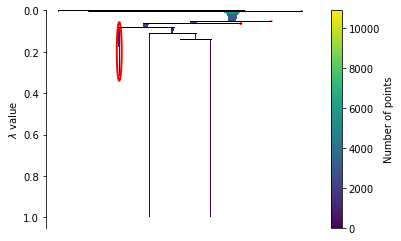

In [11]:
#hdbscan_clusterer.condensed_tree_.plot()
hdbscan_clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


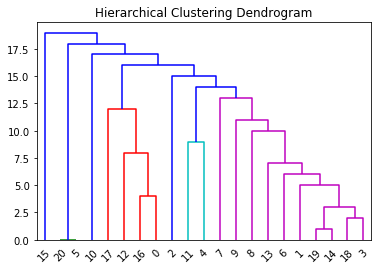

In [18]:
#Complete Linkage
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(FeatureAgglomeration_clusterer, labels=FeatureAgglomeration_clusterer.labels_)
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


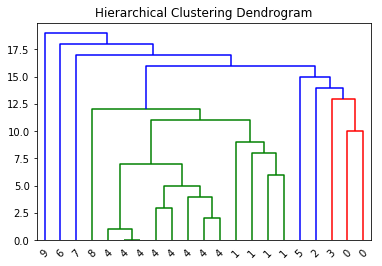

In [62]:
#Ward Linkage
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(FeatureAgglomeration_clusterer, labels=FeatureAgglomeration_clusterer.labels_)
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


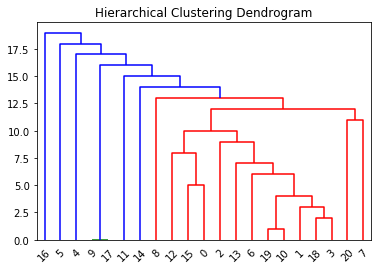

In [31]:
#single Linkage
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(FeatureAgglomeration_clusterer, labels=FeatureAgglomeration_clusterer.labels_)
plt.show()

In [33]:
#Birch
htree.display_tree()
print('Total number of subclusters:', htree.tree_size)

[cluster_id=0] N_children: 13 N_samples: 125
> [cluster_id=1] N_children: 0 N_samples: 1
> [cluster_id=2] N_children: 0 N_samples: 15
> [cluster_id=3] N_children: 0 N_samples: 15
> [cluster_id=4] N_children: 0 N_samples: 20
> [cluster_id=5] N_children: 0 N_samples: 8
> [cluster_id=6] N_children: 0 N_samples: 9
> [cluster_id=7] N_children: 0 N_samples: 2
> [cluster_id=8] N_children: 0 N_samples: 19
> [cluster_id=9] N_children: 0 N_samples: 4
> [cluster_id=10] N_children: 0 N_samples: 14
> [cluster_id=11] N_children: 0 N_samples: 9
> [cluster_id=12] N_children: 0 N_samples: 2
> [cluster_id=13] N_children: 0 N_samples: 7
Total number of subclusters: 14


In [ ]:
spanner = get_cluster_spanner(FeatureAgglomeration_clusterer)
leaf_labels = FeatureAgglomeration_clusterer.labels_
newick_tree = build_Newick_tree(FeatureAgglomeration_clusterer.children_,FeatureAgglomeration_clusterer.n_leaves_,dataset_df,leaf_labels,spanner) # leaf_labels is a list of labels for each entry in X
tree = ete3.Tree(newick_tree)
tree.show()

In [10]:
np.unique(Birch_clusterer.labels_)

array([0, 1, 2])

In [5]:
sc = htree.flatten()[13]
print(sc)


<BirchSubcluster 1a26f0f728: "{'document_id': [42, 53, 88, 96, 98, 99, 111], 'cluster_id': 13, 'document_id_accumulated': [42, 53, 88, 96, 98, 99, 111], 'cluster_size': 7}">
  * parent: BirchSubcluster[subcluster_id=0]
  * children: []



In [ ]:
class birch(object):

    def __init__(self,threshold=0.5,branching_factor=20,n_clusters=None):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.n_clusters = n_clusters
        self.Birch_clusterer = Birch(threshold=self.threshold, branching_factor=self.branching_factor,
                                     n_clusters=self.n_clusters,compute_sample_indices=True)
    
    def fit(self,data):
        self.data = data
        #self.data.drop(self.data.columns[len(self.data.columns)-1], axis=1, inplace=True)
        self.Birch_clusterer.fit(self.data)

    def get_cluster_labels(self):
        self.htree, n_clusters = birch_hierarchy_wrapper(self.Birch_clusterer)
        clusters = {}
        for i in range(n_clusters):
            sub_cluster = self.htree.flatten()[i]
            depth = sub_cluster.current_depth)
            if depth not in clusters.keys():
            if i not in clusters.keys():
                clusters[i] = {}
            if sub_cluster.current_depth == 0:
                clusters[i]['parent'] = None
            else:
                clusters[i]['parent'] = sub_cluster.parent['cluster_id']
            clusters[i]['depth'] = sub_cluster.current_depth
            clusters[i]['size'] = sub_cluster['cluster_size']
            clusters[i]['data_points'] = sub_cluster['document_id_accumulated']
            clusters[i]['centroid'] = self.data.iloc[sub_cluster['document_id_accumulated'], :].mean(axis=0).values
        return clusters
    
    def show_clutser_tree(self):
        self.htree.display_tree()
        
    def predict(self,data):
        return self.Birch_clusterer.predict(data)

In [8]:
clusters = {}
for i in range(n_clusters):
    sub_cluster = htree.flatten()[i]
    print(dataset_df.iloc[sc['document_id_accumulated'], :].mean(axis=0).values)
    if i not in clusters.keys():
        clusters[i] = {}
    if sub_cluster.current_depth == 0:
        clusters[i]['parent'] = None
    else:
        clusters[i]['parent'] = sub_cluster.parent['cluster_id']
    clusters[i]['size'] = sub_cluster['cluster_size']
    clusters[i]['data_points'] = sub_cluster['document_id_accumulated']

[1.65714286e+01 2.42857143e+00 1.42857143e-01 1.35714286e+01
 5.60000000e+01 6.80000000e+01 6.00000000e+00 8.00000000e+00
 1.27142857e+01 7.32639616e-01 4.39428571e+02 9.16666667e-01
 1.00000000e+00 4.72793084e-01 3.13780121e-01 7.14285714e-01
 1.00000000e+00 2.65722140e+01 4.57142857e+00 1.31052857e+00]
[1.65714286e+01 2.42857143e+00 1.42857143e-01 1.35714286e+01
 5.60000000e+01 6.80000000e+01 6.00000000e+00 8.00000000e+00
 1.27142857e+01 7.32639616e-01 4.39428571e+02 9.16666667e-01
 1.00000000e+00 4.72793084e-01 3.13780121e-01 7.14285714e-01
 1.00000000e+00 2.65722140e+01 4.57142857e+00 1.31052857e+00]
[1.65714286e+01 2.42857143e+00 1.42857143e-01 1.35714286e+01
 5.60000000e+01 6.80000000e+01 6.00000000e+00 8.00000000e+00
 1.27142857e+01 7.32639616e-01 4.39428571e+02 9.16666667e-01
 1.00000000e+00 4.72793084e-01 3.13780121e-01 7.14285714e-01
 1.00000000e+00 2.65722140e+01 4.57142857e+00 1.31052857e+00]
[1.65714286e+01 2.42857143e+00 1.42857143e-01 1.35714286e+01
 5.60000000e+01 6.800

In [61]:
clusters

{0: {'parent': None,
  'size': 125,
  'data_points': [57,
   1,
   3,
   6,
   34,
   35,
   38,
   45,
   62,
   71,
   91,
   93,
   102,
   103,
   114,
   119,
   8,
   11,
   20,
   24,
   28,
   30,
   39,
   52,
   65,
   66,
   82,
   94,
   97,
   107,
   108,
   2,
   17,
   18,
   19,
   23,
   25,
   29,
   31,
   40,
   49,
   54,
   59,
   61,
   67,
   73,
   84,
   87,
   106,
   109,
   110,
   37,
   47,
   48,
   64,
   72,
   81,
   101,
   104,
   14,
   44,
   46,
   50,
   63,
   68,
   77,
   118,
   123,
   78,
   120,
   4,
   5,
   10,
   27,
   32,
   33,
   51,
   58,
   76,
   79,
   80,
   92,
   95,
   112,
   113,
   115,
   116,
   117,
   121,
   22,
   26,
   36,
   56,
   7,
   13,
   16,
   41,
   43,
   75,
   83,
   85,
   86,
   90,
   100,
   105,
   122,
   124,
   0,
   9,
   12,
   15,
   21,
   55,
   69,
   70,
   74,
   60,
   89,
   42,
   53,
   88,
   96,
   98,
   99,
   111]},
 1: {'parent': 0, 'size': 1, 'data_points': [57]},
 2: {'

In [68]:
from sklearn.ensemble import ExtraTreesClassifier
def tfs(df,n_estimators=50):
    features = df.columns[:-1]
    target = df.columns[-1]
    X = df.drop(labels = [target], axis=1)
    y = df[target]
    clf = ExtraTreesClassifier(n_estimators=n_estimators)
    clf.fit(X,y)
    return clf.feature_importances_

In [69]:
tfs(dataset_df1)

array([0.06540965, 0.03469486, 0.01967495, 0.04719649, 0.09994755,
       0.07417833, 0.052023  , 0.0690375 , 0.03202788, 0.05735506,
       0.08596519, 0.02247546, 0.03162374, 0.045597  , 0.07518032,
       0.03022025, 0.02782385, 0.05280186, 0.03656176, 0.04020529])

In [8]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
target = dataset_df1.columns[-1]
X = dataset_df1.drop(labels = [target], axis=1)
y = dataset_df1[target]
lsvc = LinearSVC(C=0.01, penalty="l2", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
model.get_support(indices=False)

array([False,  True, False,  True, False, False,  True,  True, False,
        True, False, False, False, False,  True, False, False, False,
       False, False])

In [7]:
model.get_support(indices=False)

array([ True, False, False,  True,  True, False, False, False,  True,
       False,  True, False, False, False, False, False, False,  True,
       False, False])